### 1. Data

### Graphs setup

Based on the available data, you will create two graphs to model our relationships as follows:

1.Citation graph: This graph should represent the paper's citation relationships. We want this graph to be unweighted and directed. The citation should represent the citation given from one paper to another. For example, if paper A has cited paper B, we should expect an edge from node A to B.

2.Collaboration graph: This graph should represent the collaborations of the paper's authors. This graph should be weighted and undirected. Consider an appropriate weighting scheme for your edges to make your graph weighted.

### Data pre-processing
The dataset is quite large and may not fit in your memory when you try constructing your graph. So, what is the solution? You should focus your investigation on a subgraph. You can work on the most connected component in the graph. However, you must first construct and analyze the connections to identify the connected components.

As a result, you will attempt to approximate that most connected component by performing the following steps:

1.Identify the top 10,000 papers with the highest number of citations.

2.Then the nodes of your graphs would be as follows:

Citation graph: you can consider each of the papers as your nodes

Collaboration graph: the authors of these papers would be your nodes

3.For the edges of the two graphs, you would have the following cases:

Citation graph: only consider the citation relationship between these 10,000 papers and ignore the rest.

Collaboration graph: only consider the collaborations between the authors of these 10,000 papers and ignore the rest.

In [1]:
# first import required libraries:
import pandas as pd
import numpy as np
import ijson
import matplotlib.pyplot as plt
import networkx as nx
import time
import os
from tqdm.notebook import tqdm
import ast
from scipy.stats import scoreatpercentile
from networkx.algorithms.flow import edmonds_karp
import random


Due to the voluminous nature of the data, it is necessary to convert it into a CSV file for the purpose of cleaning and reducing its size.The code was initially on Kaggle but required some modifications for optimal performance. After converting it into a CSV file, we can efficiently handle the data in less time. Following the specified details in the question, I transformed the number of citations into numeric values. Subsequently, I sorted the data to identify the top 10,000 papers with the highest number of citations.

In [2]:
# json file path in my local memory
json_file_path = '.\dblp.v12.json'

articles = []

# iterating through all the papers in json file and clean the data and append them into 'articles' list
with open(json_file_path, "rb") as f:
    for i, element in tqdm(enumerate(ijson.items(f, "item"))):
       
        paper1={}

        paper1['id'] = element['id']

        paper1['title'] = element['title']

        authors =element.get('authors')
        if authors:
            paper1['authors'] = authors
        else:
            paper1['authors'] = np.nan

        year = element.get('year')
        if year:
            paper1['year'] = year
        else:
            paper1['year'] = np.nan

        n_citation = element.get('n_citation')
        if n_citation:
            paper1['n_citation'] = element['n_citation']
        else:
            paper1['n_citation'] = 0
            
        references = element.get('references')
        if references:
            paper1['reference_count'] = len(references)
            # joining all refs id in a `;` seperated string
            paper1['references'] = ';'.join([str(int(r)) for r in references])
        else:
            paper1['reference_count'] = np.nan
            paper1['references'] = np.nan

        publisher = element.get('publisher')
        if publisher:
            paper1['publisher'] = element['publisher']
        else:
            paper1['publisher'] = np.nan

        doc_type = element.get('doc_type')
        if doc_type:
            paper1['doc_type'] = element['doc_type']
        else:
            paper1['doc_type'] = np.nan
            
        doi = element.get('doi')
        if doi:
            paper1['doi']= f"https://doi.org/{element['doi']}"
        else:
            paper1['doi']= np.nan 
            
        #append each paper as a dict to the 'articles' list
        articles.append(paper1)

0it [00:00, ?it/s]

In [3]:
# the number of all the papers which should be 4,894,081
len(articles)

4894081

In [4]:
df = pd.DataFrame(articles)
df

,id,title,authors,year,n_citation,reference_count,references,publisher,doc_type,doi
0,1091,Preliminary Design of a Network Protocol Learn...,"[{'name': 'Makoto Satoh', 'org': 'Shinshu Univ...",2013.0,1,2.0,2005687710;2018037215,"Springer, Berlin, Heidelberg",Conference,https://doi.org/10.1007/978-3-642-39476-8_19
1,1388,Further Results on Independence in Direct-Prod...,"[{'name': 'Pranava K. Jha', 'id': 2718958994}]",2000.0,1,NaN,NaN,NaN,Journal,NaN
2,1674,A methodology for the physically accurate visu...,"[{'name': 'G. Beale', 'org': 'Archaeological C...",2011.0,1,15.0,1535888970;1992876689;1993710814;2035653341;20...,Eurographics Association,Conference,https://doi.org/10.2312/VAST/VAST11/137-144
3,1688,"Comparison of GARCH, Neural Network and Suppor...","[{'name': 'Altaf Hossain', 'org': 'Department ...",2009.0,6,3.0,1560724230;1986968751;2156909104,"Springer, Berlin, Heidelberg",Conference,https://doi.org/10.1007/978-3-642-11164-8_97
4,5411,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,"[{'name': 'Rafael Álvarez', 'id': 2125293936},...",2009.0,0,NaN,NaN,NaN,Conference,NaN
...,...,...,...,...,...,...,...,...,...,...
4894076,99905544,A Naïve-Bayesian methodology to classify echo ...,"[{'name': 'S. Nandagopalan', 'org': 'Dept. of ...",2010.0,2,8.0,1562217771;1625504505;2015022770;2108751703;21...,"Springer, Berlin, Heidelberg",Conference,https://doi.org/10.1007/978-3-642-24788-0_15
4894077,99884553,Blind Equalization for underwater communications,"[{'name': 'Koen Cornelis Hubertus Blom', 'org'...",2014.0,0,NaN,NaN,University of Twente,NaN,https://doi.org/10.3990/1.9789036536806
4894078,999847014,Technical Implementation and Feasibility,"[{'name': 'Gert Læssøe Mikkelsen', 'org': 'Ale...",2015.0,1,6.0,1940933138;1975620021;1978183200;2097595927;21...,Springer International Publishing,NaN,https://doi.org/10.1007/978-3-319-14439-9_9
4894079,9990887,Knowledge Patterns in Databases,"[{'name': 'Rajesh Natarajan', 'org': 'Indian I...",2011.0,0,NaN,NaN,IGI Global,NaN,https://doi.org/10.4018/978-1-59904-931-1.ch081


In [5]:
# turn the 'n_citation' column into numeric values
df['n_citation'] = pd.to_numeric(df['n_citation'], errors='coerce')

In [2]:
# Now, we can utilize the path of the CSV file to handle the data seamlessly
file_path='.\Other\sorted_sliced_10,000_data.csv'
df_10000=pd.read_csv(file_path)
df_10000

,id,title,authors,year,n_citation,reference_count,references,publisher,doc_type,doi
0,2041404167,The Mathematical Theory of Communication,"[{'name': 'C. E. Shannon', 'org': 'External Or...",1949.0,48327,NaN,NaN,NaN,Book,NaN
1,1639032689,"Genetic algorithms in search, optimization, an...","[{'name': 'David E. Goldberg', 'id': 2102678951}]",1989.0,44175,NaN,NaN,NaN,Book,NaN
2,2912565176,Fuzzy sets,"[{'name': 'Lotfi A. Zadeh', 'id': 2252586558}]",1996.0,42437,NaN,NaN,NaN,NaN,NaN
3,2151103935,Distinctive Image Features from Scale-Invarian...,"[{'name': 'David G. Lowe', 'org': 'Computer Sc...",2004.0,35541,33.0,19720318;1541642243;1560959218;1676552347;1681...,Kluwer Academic Publishers,Journal,https://doi.org/10.1023/B:VISI.0000029664.9961...
4,2911964244,Random Forests,"[{'name': 'Leo Breiman', 'org': 'Statistics De...",2001.0,34741,11.0,1507255258;1580948147;1605688901;1975846642;20...,NaN,NaN,https://doi.org/10.1023/A:1010933404324
...,...,...,...,...,...,...,...,...,...,...
9995,1964830323,An overview of JML tools and applications,"[{'name': 'Lilian Burdy', 'org': 'INRIA Sophia...",2005.0,596,82.0,1486696980;1489778371;1492315860;1498946538;14...,Springer-Verlag,Conference,https://doi.org/10.1007/s10009-004-0167-4
9996,2060553764,Trust and e-commerce: a study of consumer perc...,"[{'name': 'Brian J. Corbitt', 'org': 'School o...",2003.0,596,7.0,1492586516;1515344919;1572145800;1704743582;17...,Elsevier,Journal,https://doi.org/10.1016/S1567-4223(03)00024-3
9997,2068691410,Geographic routing in city scenarios,"[{'name': 'Christian Lochert', 'org': 'Heinric...",2005.0,596,4.0,1554193878;2101963262;2151800518;2156689181,ACM,Journal,https://doi.org/10.1145/1055959.1055970
9998,2147343704,EVENODD: an efficient scheme for tolerating do...,"[{'name': 'M. Blaum', 'org': 'IBM Almaden Rese...",1995.0,596,9.0,1530042190;1531975040;1820898047;1829547464;20...,IEEE Computer Society,Journal,https://doi.org/10.1109/12.364531


### Citation Graph:

This graph should represent the paper's citation relationships.<br>

1. Let's create a graph and name it.<br>
2. It should be **unweighted** and **directed**.<br>
3. Nodes: each of the papers as your nodes
   - Generating a list of nodes based on the id
   - Add attributes to each node based on the other columns of the dataframe<br>

4. Edges: the citation relationship between these 10,000 papers
   - Generating edges based on the citation found in the **'references'** column
   - When generating edges, check for this line of the assignment: only consider the citation relationship between these 10,000 papers and ignore the rest.

In [3]:
#  Citation Graph:
G_citation=nx.DiGraph()
G_citation.name = "citation graph"

In [4]:
# Generating a list of valid node IDs
valid_node_ids = [int(node) for node in df_10000['id']]

# iterating through all rows to generate nodes with their attributes
for index, row in df_10000.iterrows():
    
    attributes={}
    for i in list(df_10000.columns[1:]):
        attributes[i]=row[i]
    
    source_node = row['id'] 
    
    G_citation.add_node(source_node, **attributes)  
    
    # check for references column which are our nodes
    if not pd.isna(row['references']):
        #list of edges for each node
        edges = [int(x) for x in row['references'].split(';')]
        for target_node in edges:
            # remove nodes that are not among the valid 10,000 nodes
            if target_node in valid_node_ids:
                G_citation.add_edge(source_node, target_node)
                
    # Check for an empty references column; if nodes meet this condition, they are
    # generated without any edges
    elif pd.isna(row['references']):
        G_citation.add_node(row['id'])
    
print(f"Total number of nodes in the citation graph : {len(G_citation.nodes())}")
print(f"Total number of edges in the citation graph : {len(G_citation.edges())}")

Total number of nodes in the citation graph : 10000
Total number of edges in the citation graph : 52252


In [5]:
# check for a random node inorder to check the attribute
G_citation.nodes()[2041404167]

{'title': 'The Mathematical Theory of Communication',
 'authors': "[{'name': 'C. E. Shannon', 'org': 'External Organizations', 'id': 2247248564}]",
 'year': 1949.0,
 'n_citation': 48327,
 'reference_count': nan,
 'references': nan,
 'publisher': nan,
 'doc_type': 'Book',
 'doi': nan}

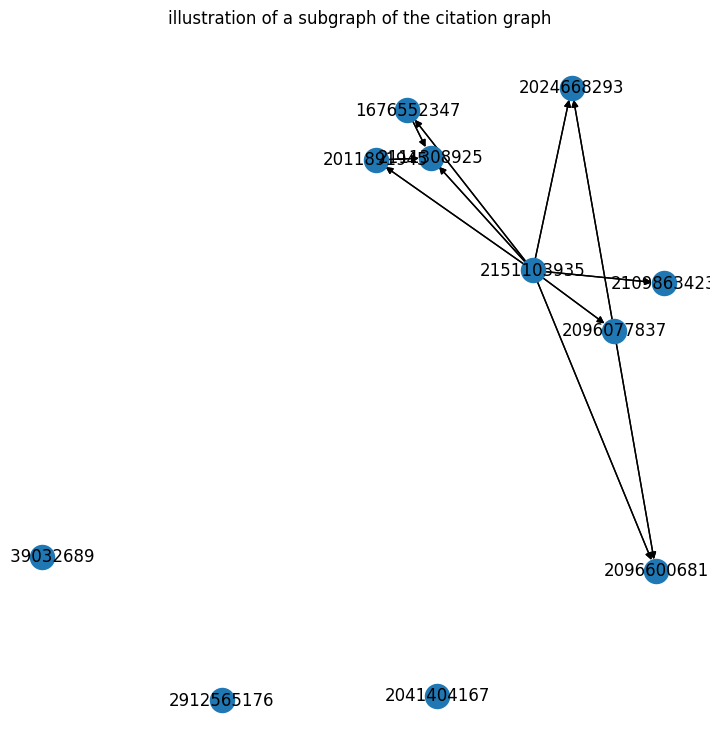

In [6]:
# Generating a subgraph of nodes for illustration purposes.
sub_graph = G_citation.subgraph(list(G_citation.nodes())[:11])
position = nx.spring_layout(sub_graph)
plt.figure(figsize=(7,7))
nx.draw(sub_graph, with_labels=True, pos= position)
nx.draw_networkx_edges(sub_graph, pos=position)
plt.title('illustration of a subgraph of the citation graph')
plt.show()

### Collaboration graph

This graph should represent the collaborations of the paper's authors.<br>
1-let's create a graph and name it.<br>
2-it should be **weighted** and **undirected**.<br>
3-nodes: the authors of these papers(10,000 papers) are nodes<br>
 - generating set and list of nodes based on the id of each author
 - add attributes to each nodes based on the data provided for each author+ the name of their articles<br>
 
4-edges: only consider the collaborations between the authors of these 10,000 papers and ignore the rest.<br>
 - generating edges based on the collaboration of aech author with their peers on a paper<br>
 - When generating edges, assign weights to the graph based on the number of collaborations each author has had with their peers.

In [7]:
#  collaboration Graph:
G_collab=nx.Graph()
G_collab.name = "collaboration graph"

In [8]:
# import required library:
from itertools import combinations

# Create a set to ensure the uniqueness of author's IDs.
nodes_set = set()

# iterating through all rows to generate nodes with their attributes
for index, row in df_10000.iterrows():  
    # create a list of authors for each paper and iterate through each
    # author to add nodes and edges to the graph
    list_id_authors=[]
    for aouthor in ast.literal_eval(row['authors']):
        list_id_authors.append(aouthor['id'])
        # Node does not exist we should create it with its attribute
        if aouthor['id'] not in nodes_set:
            #attributes of each node
            attributes={'articles':[]}
            attributes['name']=aouthor['name']
            attributes['articles'].append(row['title'])
            if 'org' in aouthor:
                attributes['org']=aouthor['org']
            #generating each node with its attribute for the first time
            G_collab.add_node(aouthor['id'],**attributes)
            #add node to the node sets to check the uniqueness and update attributes
            nodes_set.add(aouthor['id'])
            
        #if nodes exist, then just update the 'article' attribute
        elif aouthor['id'] in nodes_set:
            current_articles = G_collab.nodes[aouthor['id']]['articles']
            current_articles.extend([row['title']])
            G_collab.nodes[aouthor['id']]['articles'] = current_articles
    
    # check all the papers have authors information        
    if len(list_id_authors)<1:
        print(f"there is no aouthor in this {index}")
        
    # Generate edges for nodes and assign each edge a weight based on the number of collaborations between authors 
    elif len(list_id_authors)==2:
        source_node=list_id_authors[0]
        target_node=list_id_authors[1]
        if  G_collab.has_edge(source_node, target_node):
            G_collab[source_node][target_node]['weight'] += 1
        else: 
            G_collab.add_edge(source_node, target_node,weight=1)
            
    # Generate edges for nodes and assign each edge a weight based on the number of collaborations between authors 
    elif len(list_id_authors)>2:
        all_combinations = list(combinations(list_id_authors, 2))
        for combination in all_combinations:
            source_node=combination[0]
            target_node=combination[1]
            if  G_collab.has_edge(source_node, target_node):
                G_collab[source_node][target_node]['weight'] += 1
            else: 
                G_collab.add_edge(source_node, target_node,weight=1)
        
print(f"Total number of nodes in the collaboration graph : {len(G_collab.nodes())}")
print(f"Total number of edges in the collaboration graph : {len(G_collab.edges())}")

Total number of nodes in the collaboration graph : 21235
Total number of edges in the collaboration graph : 136478


In [9]:
# to check the attribute of the most active author in the first 10,000 papers with the highest number of citation
G_collab.nodes()[161269817]

{'articles': ['Deep Learning',
  'Generative Adversarial Nets',
  'Neural Machine Translation by Jointly Learning to Align and Translate',
  'Understanding the difficulty of training deep feedforward neural networks',
  'Representation Learning: A Review and New Perspectives',
  'Learning Deep Architectures for AI',
  'A neural probabilistic language model',
  'Stacked Denoising Autoencoders: Learning Useful Representations in a Deep Network with a Local Denoising Criterion',
  'Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation',
  'Extracting and composing robust features with denoising autoencoders',
  'Greedy Layer-Wise Training of Deep Networks',
  'Learning long-term dependencies with gradient descent is difficult',
  'Empirical evaluation of gated recurrent neural networks on sequence modeling',
  'Show, Attend and Tell: Neural Image Caption Generation with Visual Attention',
  'Random search for hyper-parameter optimization',
  'Learni

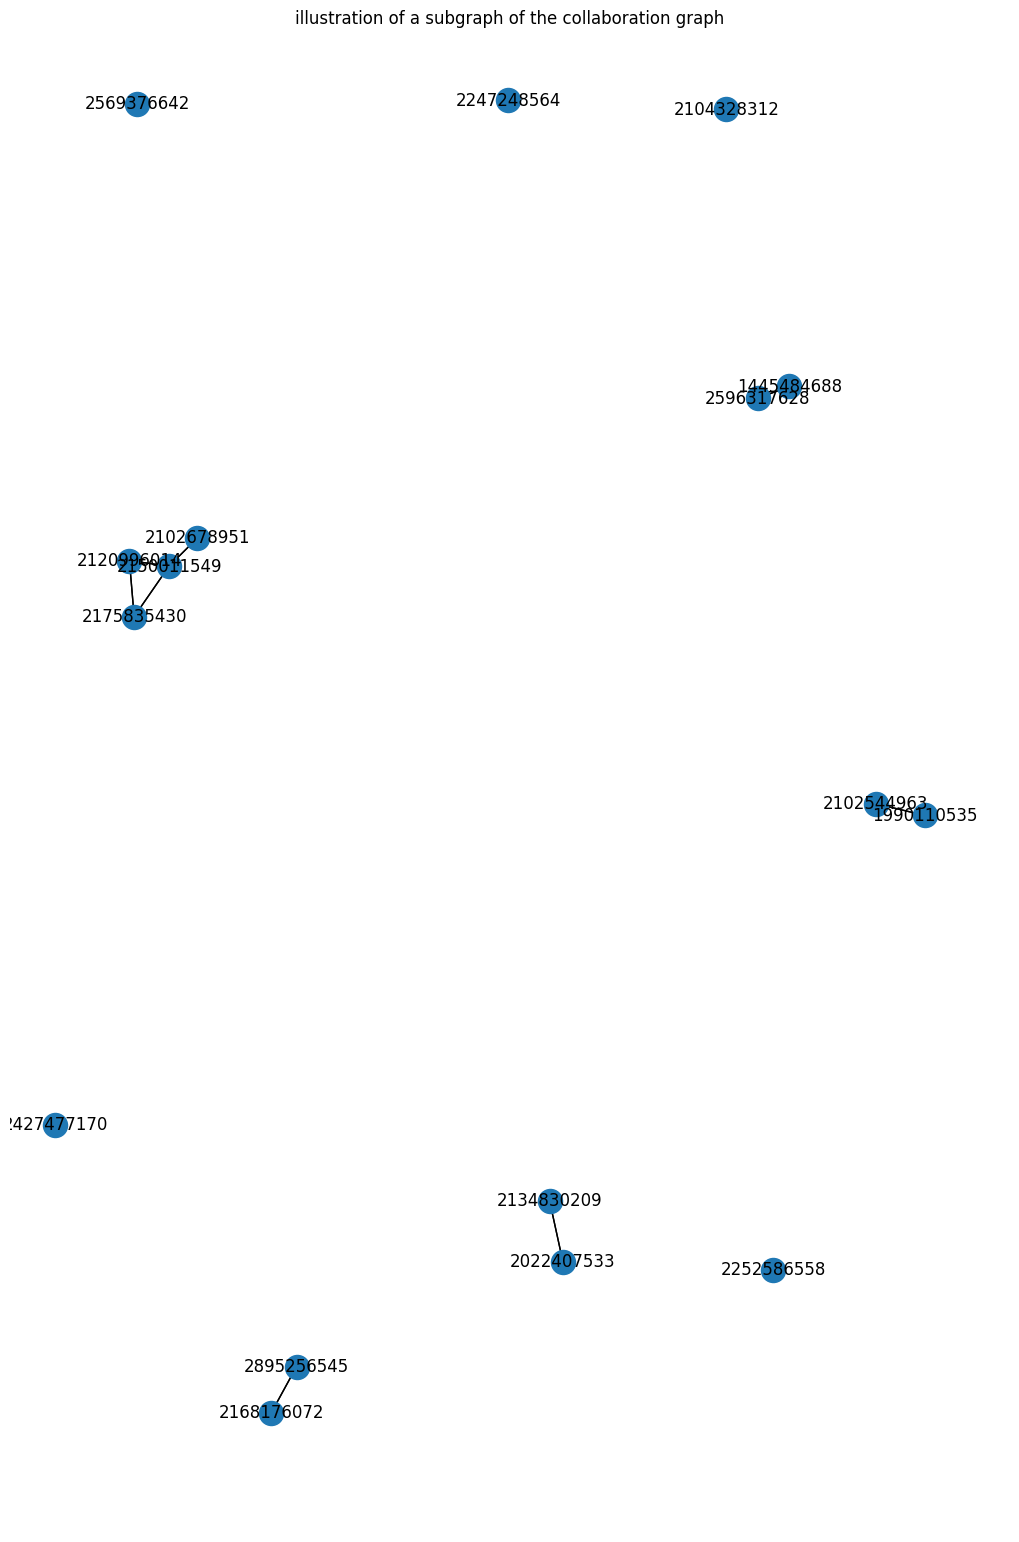

In [10]:
# Generating a subgraph of nodes for illustration purposes.
sub_collab_graph = G_collab.subgraph(list(G_collab.nodes())[:17])
position = nx.spring_layout(sub_collab_graph)
plt.figure(figsize=(10,15))
nx.draw(sub_collab_graph, with_labels=True, pos= position)
nx.draw_networkx_edges(sub_collab_graph, pos=position)
plt.title('illustration of a subgraph of the collaboration graph')
plt.show()

# 2. Controlling system

Please keep the following in mind for both the backend and frontend components. The plan is to put in place a control system. You will provide the user with a menu from which he can select different functionalities. The user should be able to select from one of five different functionalities that you will implement in the following two sections. We want to have such a system so that the user can query different functionalities that he is interested in. 

Your function should be designed in such a way that it provides the most flexibility to the user. For example, when the user selects functionality 1, which provides some high-level information about the graph, you can allow him to pass an argument indicating which of the two types of graphs he wants to be analyzed (That is why the name of the graph is one of the arguments in the first functionality). 

You will implement the functionalities in the Backend section. The Frontend section primarily discusses the menu that you must provide to the user, as well as the expected results that should be displayed to the user after selecting each of the functionalities. 

## 2.1. Backend Implementation
This section describes what each of the functionalities should be. 

### Functionality 1 - Graph's features
This function should examine a graph and report on some of its features. The input and report that this function should produce are shown below. 

Input: 
- The graph
- The name of the graph

Output: 
- The number of the nodes in the graph
- The number of the edges in the graph
- The graph density
- The graph degree distribution
- The average degree of the graph
- The graph hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
- Whether the graph is dense or sparse

---

Let's define a function, called `functionality_1`, that conducts an analysis of a given graph. 
The analysis includes various metrics and visualizations to provide insights into the structure of the graph.

The analysis covers the following aspects:
1. **Number of Nodes and Edges:**
   - Provides the total number of nodes and edges in the graph.

2. **Graph Density:**
   - The density of a graph is a measure of how many edges are present in the graph compared to the total number of possible edges. It is used to characterize how sparse or dense a graph is.  The value ranges from 0 to 1, and if the density is greater than 0.5, we can consider the graph as dense; otherwise, it is considered sparse.

3. **Degree Distribution:**
   - Obtaining the degree distribution to understand the connectivity patterns within the graph. This involves creating a histogram representing the frequencies of nodes for each degree.

4. **Average Degree:**
   - Calculates the average degree of nodes in the graph.

5. **Graph Hubs:**
   - A hub is essentially a central or highly connected node within a graph. This function returns the list of nodes that act as hubs, identified as the nodes with a degree greater than or equal to the 95th percentile.


In [11]:
def functionality_1(graph, graph_name):
    # Number of nodes
    num_nodes = graph.number_of_nodes()

    # Number of edges
    num_edges = graph.number_of_edges()

    # Graph density
    density = nx.density(graph)

    # Degree distribution
    degree_sequence = [d for n, d in graph.degree()]
    
    degree_distribution = nx.degree_histogram(graph)

    # Dictionary with keys: degree and value: frequency
    dict_degree_distribution = {}
    for i, freq in enumerate(degree_distribution):
        dict_degree_distribution[i] = freq
    
    # Average degree
    avg_degree = np.mean(degree_sequence)

    # 95th percentile of the degree distribution
    percentile_95 = scoreatpercentile(degree_sequence, 95)

    # Graph hubs
    hubs = [node for node, degree in graph.degree() if degree >= percentile_95]

    # Whether the graph is dense or sparse
    if density >= 0.5:
        density_status = "dense"
    else:
        density_status = "sparse"
    
    # Return computed values
    return {
        "num_nodes": num_nodes,
        "num_edges": num_edges,
        "density": density,
        "degree_distribution": degree_distribution,
        "avg_degree": avg_degree,
        "hubs": hubs,
        "density_status": density_status
    }

# Example usage
graph_name = "Citation Graph"
result = functionality_1(G_citation, graph_name)
print(result)

{'num_nodes': 10000, 'num_edges': 52252, 'density': 0.0005225722572257226, 'degree_distribution': [572, 598, 683, 639, 594, 581, 607, 589, 515, 477, 418, 406, 364, 343, 260, 239, 211, 222, 179, 162, 147, 138, 105, 111, 88, 63, 72, 62, 49, 48, 37, 38, 25, 25, 17, 32, 18, 19, 16, 16, 12, 13, 13, 18, 5, 4, 6, 8, 12, 7, 6, 5, 3, 4, 7, 6, 7, 5, 2, 5, 5, 5, 1, 3, 4, 5, 4, 2, 2, 2, 5, 1, 0, 2, 2, 1, 2, 1, 0, 1, 2, 1, 0, 0, 0, 0, 1, 0, 0, 2, 1, 2, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1], 'avg_degree': 10.4504, 'hubs': [2041404167, 1639032689, 2912565176, 2151103935, 1676552347, 2024668293, 2109863423, 2111308925, 2124087378, 2124386111, 2124404372, 2154422044, 2427881153, 2911964244, 1975846642, 2112076978, 2152761983, 2912934387, 2153635508, 2087347434, 2104978738, 2119821739, 2156909104, 1791587663, 1995875735, 2125899728, 2145023731, 2161969291, 1608

### Functionality 2 - Nodes' contribution 
Using this functionality, you will identify the papers/authors who have significantly contributed to this field of study. For this analysis, focusing solely on the number of citations for the paper or the number of collaborations of the authors can be misleading. You will examine this using various centrality measurements. 

Input:
- The graph
- A node of the graph (paper/author)
- The name of the graph

Output: 
- The centrality of the node, calculated based on the following centrality measurements:
   - [Betweeness](https://www.tandfonline.com/doi/abs/10.1080/0022250X.2001.9990249)
   - [PageRank](https://courses.cs.washington.edu/courses/cse373/17au/project3/project3-3.html)
   - [ClosenessCentrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality)
   - DegreeCentrality

---

In the second functionality, our focus is on understanding nodes' contributions in the graph by utilizing specific centrality measures. These measures provide insights into how significant a node is within the graph's structure. The following centrality measures are analyzed:

1. **Betweenness Centrality:**
   - Measures the extent to which a node lies on the shortest paths between other nodes. Nodes with high betweenness centrality play crucial roles in facilitating communication and information flow between different parts of the graph.

2. **PageRank Centrality:**
   - Represents the importance of a node based on the structure of the entire graph. Nodes with high PageRank centrality are considered important contributors to the overall graph structure.

3. **Closeness Centrality:**
   - Measures how close a node is to all other nodes in the graph. Nodes with high closeness centrality are well-connected to the rest of the graph, indicating their proximity to other nodes.

4. **Degree Centrality:**
   - Reflects the proportion of neighbors a node has relative to the total number of nodes. Nodes with high degree centrality have a large number of connections, making them central in terms of local connections within the graph.


In [15]:
def functionality_2(graph, node, graph_name):
    """Function to understand the importance of a certain node in the graph, based on some centrality measures
    """
    # We can use NetworkX library in order to calculate these measures
    betweenness = nx.betweenness_centrality(graph)[node]
    page_rank = nx.pagerank(graph)[node]
    closeness = nx.closeness_centrality(graph, u = node)
    degree_centrality = nx.degree_centrality(graph)[node]
    return betweenness, page_rank, closeness, degree_centrality

report_2 = functionality_2(G_collab, 1984280187, "collaboration_graph")
report_2

(0.00014313179484078676,
 8.429505061548062e-05,
 0.04320807607868926,
 0.013092210605632476)

### Functionality 3 - Shortest ordered walk  

Input:  
- The graph data 
- A sequence of authors\_a = [a\_2, ..., a\_{n-1}]
- Initial node a\_1 and an end node a\_n
- $N$: denoting the top $N$ authors whose data should be considered
 
Output: 
- The shortest walk of collaborations you need to read to get from author a\_1 to author a\_n and the papers you need to cross to realize this walk.
 
Considerations: 
For this functionality, you must implement an algorithm that returns the shortest __walk__ that goes from node a\_j to a\_n, which visits **in order** the nodes in _a_. The choice of a\_j and a\_n can be made randomly (or if it improves the performance of the algorithm, you can also define it in any other way) 

__Important Notes:__
- This algorithm should be run only on the collaboration graph.
- The algorithm needs to handle the case that the graph is not connected. Thus, only some nodes in _a_ are reachable from a\_1. In such a scenario, it is enough to let the program give in the output the string "There is no such path."
- Since we are dealing with walks, you can pass on the same node _a\_i_ more than once, but you must preserve order. It means you can go back to any author node any time you want, assuming that the order in which you visit the required nodes is still the same.
- Once you completed your implementation, ask chatGPT for a different one leveraging another approach in solving the shortest path and prove whether this implementation is correct. 

---

The goal of the third functionality is to identify the shortest path between two nodes, if possible. Additionally we also have to consider a sequence of authors and ensure that we visit all the nodes in this sequence in the given order, before reaching the ending node.

To do so the main idea is to implement our own Breadth-first search algorithm (BFS), tailored to our specific case. The BFS algorithm allows us to find all the paths from a source node to all the others reachable from that one, exploring all its neighbors before moving on to the next level of nodes. In our modified version, we not only explore all levels but also memorize every possible path from the starting node.

Once we have implemented the BFS, we apply it to all successive pairs of nodes that we need to traverse before reaching the target node. This ensures that the path identified is the shortest possible one.

In [12]:
def neighbors_list(graph, list_of_nodes):
    """A function to identify all the neighbors of a list of nodes.
    It's useful in the BFS_modified to analyze all the levels of the BFS algorithm.
    
    Args:
        graph (Graph): the graph we want to analyze
        list_of_nodes (list): list of nodes for which we want to identify neighbors

    Returns:
        neighbors: set of all the neighbors of the nodes in the input list
    """
    
    neighbors = set()
    
    # iterate through the list_of_nodes
    for node in list_of_nodes:
        neighbors_node = set(graph.neighbors(node)) # find the neighbors of the single node
        neighbors = neighbors.union(neighbors_node)  # add to the initial set

    return neighbors


def BFS_modified(graph, starting_node, ending_node):
    """Function to implement a modified version of the Breadth-First Search algorithm,
    to classify all the nodes of the input graphs in levels and find the shortest path between two nodes.
    
    Args:
        graph (Graph): the graph we want to analyze
        starting_node (int): starting node of the path
        ending_node (int): ending node of the path

    Returns:
        path: the list of nodes in the shortest path from the starting node to the ending one
    """
    
    # initializing all the variables to memorize data
    queue = {0: [starting_node]}    # dictionary where I memorize all the nodes
                                    # in every level of the graph, starting from the starting_node
    path = {0: [starting_node]} # dictionary where I memorize every possible path,
                                # until I find the right one
    cont = 0
    visited = {starting_node} # set of visited nodes
    cont_path = 0

    while queue != {}: 
        # Iterate through nodes in the current level
        for father in queue[cont]:
            if not any(set(graph.neighbors(father)) - visited for father in queue[cont]):
                return None  # Return None if all neighbors are visited
            
            # explore neighbors
            for child in (set(graph.neighbors(father))-visited):
                cont_path += 1
                # check if the ending_node is reached and if so return the corresponding path to reach it
                if child == ending_node:
                    matching_list = [value for value in path.values() if value[-1] == father]
                    path[cont_path] = matching_list[0] + [child] 
                    return path[cont_path]
                # else continue the exploration of the neighbors
                else:
                    matching_list = [value for value in path.values() if value[-1] == father]
                    path[cont_path] = matching_list[0] + [child]
                cont_path += 1
        
        # Add the visited nodes to the initial set
        actual = neighbors_list(graph, queue[cont]) - visited
        queue[cont+1] = list(actual)
        cont += 1
        visited = visited.union(actual)
        
        # Remove an empty set from the queue
        if queue[cont] == set():
            queue.pop(cont)
            break
    
    # return None if there's no path to connect the two nodes
    return None

path = BFS_modified(G_collab, 1990110535, ending_node=2296124051)
path

[1990110535, 2102544963, 2296124051]

Now that we have implemented the modified version of the BFS between two nodes, it is sufficient to apply this algorithm to every pair of nodes to identify the shortest path.

Moreover, we also need to create the subgraph based on the first authors if the user wants to consider only N of them.

In [13]:
def top_N_nodes(G, N):
    """Function to create the subgraph, considering only the first N most influential authors.

    Args:
        G (graph): graph
        N (int): number of most influential authors we want to consider

    Returns:
        graph_auth: the subgraph
    """
    
    # calculate the degree of each node in the graph and store it
    degrees = dict(G.degree())
    # sort authors by degree and select the first N
    N_authors = sorted(degrees.items(),key=lambda x:x[1],reverse=True)[:N]
    N_authors_id = [el[0] for el in N_authors] # extract only the node IDs from the sorted list
    subgraph = G.subgraph(N_authors_id)
    
    return subgraph


def shortest_ordered_walk(graph, authors_a, starting_node, ending_node, N):
    """Function to compute the shortest path between 2 nodes, passing through all the nodes in the authors_a list.
    It uses the functions defined before to perform it.
    
    Args:
        graph (Graph): the graph we want to analyze
        authors_a (list): list of nodes we want to see before reaching the target one
        starting_node (int): starting node of the path
        ending_node (int): ending node of the path
        N (int): number of most influential authors we want to consider

    Returns:
        path: the shortest path to reach ending_node from the starting_node
    """
    
    graph = top_N_nodes(graph, N) # subgraph considering only the N most influential authors
    # creating the list of nodes we want to visit in order
    authors_a.insert(0, starting_node)
    authors_a.append(ending_node)
    
    # initialize the full path
    list = []
    for index in range(len(authors_a)-1):
        # if BFS_modified functions return None means that there is no such path
        if BFS_modified(graph, starting_node=authors_a[index], ending_node=authors_a[index+1]) == None:
            print(authors_a[index], authors_a[index+1])
            return("There is no such path!")
        # else we can add this subpath (obtained from all the couples of nodes of the authors_a list) to the main one
        else:
            list += BFS_modified(graph, starting_node=authors_a[index], ending_node=authors_a[index+1])

    # Deleting duplicate consecutive elements in the list
    unique_path = [list[0]]  

    for value in list[1:]:
        if value != unique_path[-1]:
            unique_path.append(value)

    return unique_path

path = shortest_ordered_walk(G_collab, [1973035492], starting_node=332422508, ending_node=1984280187, N = 1000)
path

[332422508, 1973035492, 1984280187]

Now, as requested, we can experiment the implemented algorithm with different subpaths chosen randomly using.

In [14]:
random.seed(12)

n = 3 # number of nodes in the subsample
N = 100 # number of top authors we want to consider

# create the subgraph to extract the subsample
graph_top_N_authors = top_N_nodes(G_collab, N = 100)
subsample = random.sample(list(graph_top_N_authors.nodes()), n)
random_nodes = random.sample(list(graph_top_N_authors.nodes()), n)
starting_node, ending_node = random_nodes[0], random_nodes[1] # randomly selecting starting and ending node
## print(starting_node, ending_node)
## print(subsample)

path = shortest_ordered_walk(graph_top_N_authors, subsample, starting_node=starting_node, ending_node=ending_node, N = N)
print("The shortest path to reach", ending_node, "from", starting_node, ", visiting", subsample[1:n+1], "is", path)

The shortest path to reach 2111697827 from 173839695 , visiting [2193977647, 1969296054, 2512246175] is [173839695, 1973035492, 2193977647, 1969296054, 2512246175, 2111697827]


### Functionality 4 - Disconnecting Graphs

Input: 
- The graph data 
- authorA: a paper to which will relate sub-graph G\_a
- authorB: a paper to which will relate sub-graph G\_b
- $N$: denoting the top $N$ authors that their data should be considered

Output:
- The minimum number of edges (by considering their weights) required to disconnect the original graph in two disconnected subgraphs: G\_a and G\_b.

---

The fourth functionality is about disconnecting graphs. This is important for various reasons, such as identifying and isolating components within the graph and understand the relation between two nodes of a graph.

Our specific goal is to determine the minimum number of edges required to disconnect two nodes of a graph (authorA, authorB), creating two disjoint subgraphs, each containing one of the nodes.

To do that the main idea is to use an existing algorithm called Edmonds-Karp, for identifying maximum flow in directed and weighted graphs.
The algorithm operates on the residual network of the graph, which is constructed based on the disparities between edge capacities and flows. The algorithm identifies the paths through which maximum flow can traverse from the source to the sink.

After finding the residual graph, using this algorithm, we can employ the Breath-First Search (BFS) on the residual graph to identify all nodes reachable from the source. After the BFS exploration we will have two partitions: 

- `partition_one`, containing the reachable nodes.
- `partition_two`, containing the remaining nodes. 

Let's start our functionality from the code of the BFS algorithm, which is very similar to the one implemented in the previous functionality.

In [15]:
def BFS(graph, starting_node):
    """Function to implement the Breadth-First Search (BFS) algorithm,
    to classify all the nodes of the input graphs in levels.
    
    Args:
        graph (Graph): the graph we want to analyze
        starting_node (int): source node

    Returns:
        queue: 
    """
    queue = {0: [starting_node]}    # dictionary where I memorize all the nodes
                                    # in every level of the graph, starting from the starting_node    
    cont = 0
    visited = {starting_node}   # set of visited nodes

    while (neighbors_list(graph, queue[cont]) - visited) != {}:
        # Iterate through nodes in the current level
        actual = neighbors_list(graph, queue[cont]) - visited

        queue[cont+1] = actual # next level
        cont += 1
        
        # Add the visited nodes to the initial set
        visited = visited.union(actual)

        # Remove an empty set from the queue
        if queue[cont] == set():
            queue.pop(cont)
            break

    return queue[1]

Now let's define the function to compute the number of edges required to disconnect the two subgraphs.

In [16]:
def disconnecting_graphs(graph, source, sink, N):
    
    # Determine if the graph is weighted or unweighted and adjust accordingly.
    if not nx.get_edge_attributes(graph, 'weight'):
        temp_graph = graph.copy()  # Create a copy to prevent modifications to the original graph
        nx.set_edge_attributes(temp_graph, 1, 'weight')  # Assign a default weight of 1 to all edges
        graph = temp_graph

    # Check if the source and sink are already disconnected.
    if not nx.has_path(graph, source, sink):
        return [0, [], graph]

    # If a limit is set, refine the graph to the top N most connected nodes.
    graph = top_N_nodes(graph, N)

    # Apply the Edmonds-Karp algorithm to find the residual network.
    residual_graph = edmonds_karp(graph, source, sink, 'weight')
    flows = nx.get_edge_attributes(residual_graph, 'flow')
    capacities = nx.get_edge_attributes(residual_graph, 'capacity')
    
    residual_capacities = {}
    for u, v in residual_graph.edges:
        residual_capacities[u, v] = (capacities[(u, v)] - flows[(u, v)])
    
    # Use BFS to find all nodes reachable from the source in the residual graph.
    reachable = BFS(residual_graph, source)
    reachable.add(source)
    
    # Determine the cut sets based on the BFS exploration.
    partition_one = reachable
    partition_two = [node for node in graph.nodes if node not in partition_one]
    separating_edges = list(nx.edge_boundary(graph, partition_one, partition_two))

    # Return the size of the cut, the actual edges, and the modified graph.
    return (len(separating_edges), separating_edges, graph)

disconnecting_graphs(G_collab, 332422508, 1984280187, 10)

(4,
 [(1973035492, 1566488673),
  (1973035492, 1984280187),
  (1973035492, 1976452423),
  (1973035492, 2034164144)],
 <networkx.classes.graph.Graph at 0x1c8a2952250>)

### Functionality 5 - Extracting Communities

Input: 
- The graph data 
- $N$: denoting the top $N$ papers that their data should be considered
- Paper\_1: denoting the name of one of the papers 
- Paper\_2: denoting the name of one of the papers

Output:
- The minimum number of edges that should be removed to form communities
- A list of communities, each containing a list of papers that belong to them.
- Whether the Paper\_1 and Paper\_2 belongs to the same community. 

Important Notes:  
To comprehend this functionality better, we suggest you take a good look at this [article](https://www.analyticsvidhya.com/blog/2020/04/community-detection-graphs-networks/)

---

The goal of the fifth functionality is to divide the graph in communities. A community is a subset of nodes within a graph that exhibit a higher degree of connection with each other than with the rest of the nodes of the graph.

There are several methods to identify communities, we decided to use the Girvan-Newman Algorithm, based on edge betweenness centrality, in fact it iteratively removes edges with the highest betweenness centrality to reveal community structure.

So first of all we implemented the `edge_to_remove` function to identify the edge with the highest edge betweenness score and then the `girvan_newman` to iteratively remove edges. 

In [17]:
def edge_to_remove(graph):
    """Function to understand the edge to be removed, base on the betweenness centrality score

    Args:
        graph (Graph): graph

    Returns:
        tuple: edges to be removed
    """
    G_dict = nx.edge_betweenness_centrality(graph)     # Calculate edge betweenness centrality for each edge in the graph
    
    edge = ()

    # extract the edge with highest edge betweenness centrality score
    for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
        edge = key
        break

    return (len(edge), edge)

def girvan_newman(graph):
    """Girvan-Newman algorithm to identify communities

    Args:
        graph (Graph): graph
    """
    # Find initial number of connected components
    sg = nx.connected_components(graph)
    sg_count = nx.number_connected_components(graph)

    while(sg_count == 1):
        # Remove the edge with the highest betweenness centrality
        graph.remove_edge(edge_to_remove(graph)[1][0], edge_to_remove(graph)[1][1])
        sg = nx.connected_components(graph)
        sg_count = nx.number_connected_components(graph)

    return sg

def same_community(Paper_1, Paper_2, communities):
    """Function to check if Paper_1 and Paper_2 belong to the same community.


    Args:
        Paper_1 (int): Node 1
        Paper_2 (int): Node 2
        communities (list): list of the nodes in the communities

    Returns:
        Bool: True if Paper_1 and Paper_2 belong to the same community, False otherwise
    """
    for community in communities:
        if Paper_1 in community and Paper_2 in community:
            return True
    return False

Now let's merge all together to create the functionality 5 as requested.

In [18]:
def extracting_communities(graph, Paper_1, Paper_2, N):
    """Function to extract communities and to understand 
    if Paper_1 and Paper_2 belong to the same community

    Args:
        graph (Graph): graph
        Paper_1 (int): node 1
        Paper_2 (int): node 2
        N (int): Number of top authors to create the subgraph

    Returns:
        tuple: tuple with the minimum number of edges to be removed to create the community, the communities and if the two papers are in the same on
    """
    if N:
        graph = top_N_nodes(graph, N)
    
    # compute number of edges    
    number_of_edges = edge_to_remove(graph)[0]

    c = girvan_newman(graph.copy())

    # find the nodes forming the communities
    communities = []

    # insert the nodes in the communities
    for i in c:
        communities.append(list(i))
    
    same_c = same_community(Paper_1, Paper_2, communities)
    
    return (number_of_edges, communities, same_c)

extracting_communities(G_collab, 1973035492, 2120643991, 20)

(2,
 [[1566488673,
   1973035492,
   2130160582,
   1976452423,
   2502209291,
   2114532620,
   338444495,
   2034164144,
   783371218,
   1978529654,
   2126370775,
   1524700667,
   1984280187,
   2240988444],
  [332422508, 173839695, 2065847026, 2146468246, 2120643991, 2111642879]],
 False)

### Visualization 1 - Visualize graph features 
We anticipate seeing the Functionality 1 report in Visualization 1. To be more specific, we expect you to have the following report format:

 - A table containing the following general information about the graph: 
      - Number of nodes in the graph
      - Number of the edges in the graph 
      - Density of the graph
      - Average degree of the graph
      - Whether the network is sparse or dense 
 - A table that lists the graph's hubs
 - A plot depicting the distribution of the citations received by papers (Citation graph)
 - A plot depicting the distribution of the given citations by papers (Citation graph) 
 - A plot depicting the number of collaborations of the author (Collaboration graph)

__Note:__ You can plot the features for a limited number of nodes (e.g., top 20) to improve the visualization of the plots. 

---

Visualization 1 is simply a presntation of the results of functionality one, plus the two plots for the citation graph and the other one for the collaboration one.

Analysis Report for Graph 'Citation Graph':
1. Number of Nodes: 10000
2. Number of Edges: 52252
3. Graph Density: 0.0005
4. Degree distribution:


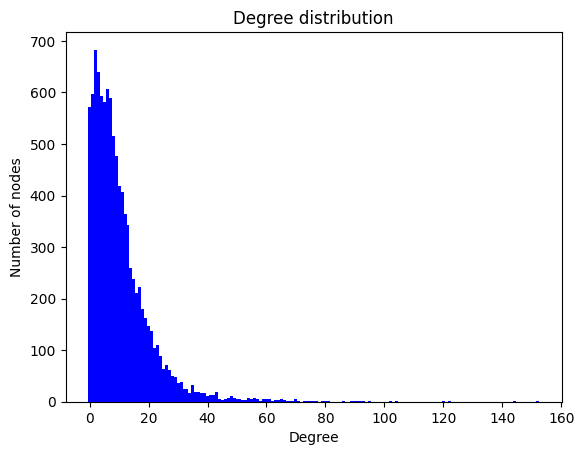

5. Average Degree: 10.45
6. Graph Hubs: [2041404167, 1639032689, 2912565176, 2151103935, 1676552347, 2024668293, 2109863423, 2111308925, 2124087378, 2124386111, 2124404372, 2154422044, 2427881153, 2911964244, 1975846642, 2112076978, 2152761983, 2912934387, 2153635508, 2087347434, 2104978738, 2119821739, 2156909104, 1791587663, 1995875735, 2125899728, 2145023731, 2161969291, 1608462934, 2121899951, 2152473410, 2172188317, 2177274842, 1880262756, 1956559956, 2097089247, 2147152072, 1686810756, 1487583988, 1606858007, 2037227137, 2102605133, 2108598243, 2147800946, 2155904486, 2161381512, 2168231600, 2179352600, 2950179405, 2952186574, 2953360861, 2963173190, 1522301498, 1810943226, 1904365287, 2146502635, 2053691921, 2107790757, 2121863487, 2011039300, 2163605009, 1665214252, 2110764733, 2130325614, 2134557905, 2546302380, 2132984323, 1667165204, 2064675550, 2107878631, 2125055259, 2085261163, 2296616510, 1986931325, 2113945798, 2116148865, 2129131372, 2129638195, 2145096794, 2147656689,

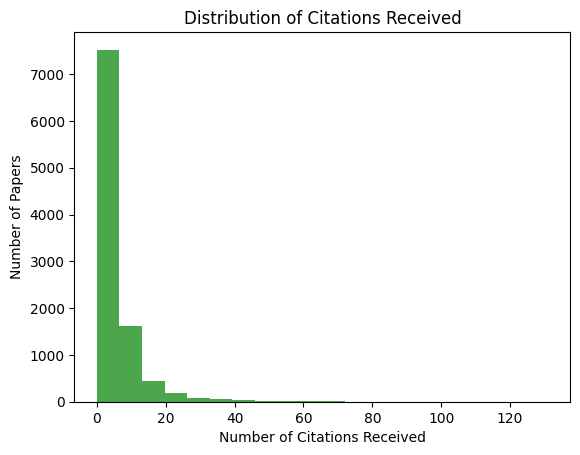

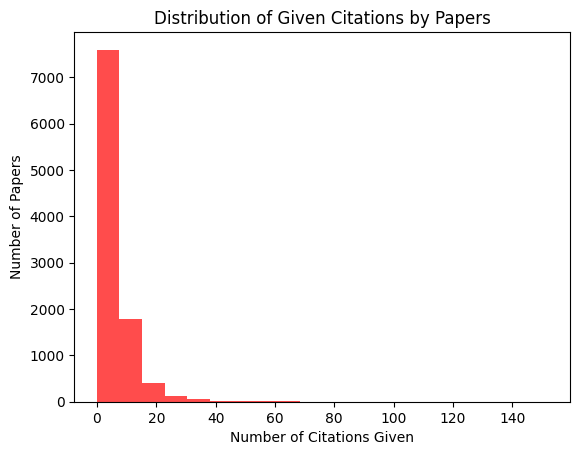

Analysis Report for Graph 'Collaboration Graph':
1. Number of Nodes: 21235
2. Number of Edges: 136478
3. Graph Density: 0.0006
4. Degree distribution:


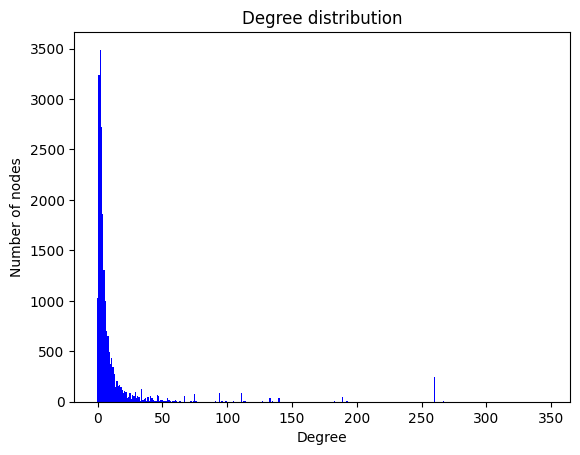

5. Average Degree: 12.85
6. Graph Hubs: [1445484688, 2104401652, 2435751034, 2007415138, 2096217197, 2146468246, 215131072, 2429370538, 2575315241, 1822555116, 161269817, 2328522601, 2304583711, 1993363060, 2079517616, 2230831812, 2147318212, 2120643991, 2141862317, 1998464616, 2098984663, 2102002796, 2308824398, 2022840042, 2668737056, 15795219, 2126370775, 338444495, 2053101140, 719828399, 2296249340, 1111049960, 2509101809, 2462121670, 2127250160, 2075956027, 2151338116, 2160198784, 2169057019, 2020844714, 295353625, 348251026, 2397241174, 2068107358, 1978529654, 2303652421, 2066408259, 2148448995, 332422508, 2020717950, 2133227394, 2114243873, 1993724977, 2099620214, 2466945765, 2115999401, 2086987877, 2137837491, 2111642879, 2112866862, 76210181, 2046931170, 2309147086, 2229209549, 2234077178, 2244314629, 2162106674, 2922418434, 2014082263, 2004792601, 2079584417, 2568636091, 2330302558, 2089062156, 2634174050, 1877008227, 370127644, 278754694, 2195817632, 2124824206, 134561875, 2

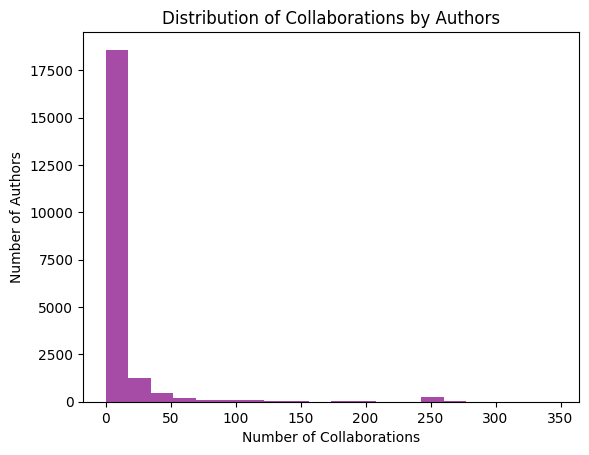

In [19]:
def visualize_functionality_1(graph, graph_name):
    # Functionality 1 computations
    result = functionality_1(graph, graph_name)

    if result is not None:
        # Presentation of the results
        print(f"Analysis Report for Graph '{graph_name}':")
        print(f"1. Number of Nodes: {result['num_nodes']}")
        print(f"2. Number of Edges: {result['num_edges']}")
        print(f"3. Graph Density: {result['density']:.4f}")

        # Visualize histograms of degree distribution
        print("4. Degree distribution:")
        plt.bar(range(len(result['degree_distribution'])), result['degree_distribution'], width=1.0, color='b')
        plt.title('Degree distribution')
        plt.xlabel('Degree')
        plt.ylabel('Number of nodes')
        plt.show()

        print(f"5. Average Degree: {result['avg_degree']:.2f}")
        print(f"6. Graph Hubs: {result['hubs']}")
        print(f"7. Graph is {result['density_status']}.")

        # Plot for Citation Graphs
        if graph_name=="Citation Graph":
            # Distribution of Citations Received
            plt.figure()
            citations_received = [graph.in_degree(node) for node in graph.nodes()]
            plt.hist(citations_received, bins=20, color='g', alpha=0.7)
            plt.title('Distribution of Citations Received')
            plt.xlabel('Number of Citations Received')
            plt.ylabel('Number of Papers')
            plt.show()

            # Distribution of Given Citations by Papers
            plt.figure()
            citations_given = [graph.out_degree(node) for node in graph.nodes()]
            plt.hist(citations_given, bins=20, color='r', alpha=0.7)
            plt.title('Distribution of Given Citations by Papers')
            plt.xlabel('Number of Citations Given')
            plt.ylabel('Number of Papers')
            plt.show()

        elif graph_name=="Collaboration Graph":
            # Distribution of Collaborations by Authors
            plt.figure()
            collaborations = [graph.degree(node) for node in graph.nodes()]
            plt.hist(collaborations, bins=20, color='purple', alpha=0.7)
            plt.title('Distribution of Collaborations by Authors')
            plt.xlabel('Number of Collaborations')
            plt.ylabel('Number of Authors')
            plt.show()


# For the citation graph
graph_name_citation = "Citation Graph"
visualize_functionality_1(G_citation, graph_name_citation)

# For the collaboration graph
graph_name_collaboration = "Collaboration Graph"
visualize_functionality_1(G_collab, graph_name_collaboration)


After running the function on both graphs we know some general informations about the two graph. Both of the are sparse, the collaboration one has more than twice the nodes and edges. As we can see from the degree distribution plot the collaboration graph has more high degree nodes(in fact also the average degree is higher).

 ### Visualization 2 - Visualize the node's contribution
We anticipate seeing the Functionality 2 report in Visualization 2. To be more specific, we expect you to have the following report format:

   - A table containing the node's centrality value based on the four centrality measurements

---


Visualization 2 is very straight forward having functionality two, we just need to print the result of the function

In [24]:
def visualize_functionality_2(result, node, graph_name):
    print(f"\nCentrality Measurements for Node {node} in Graph '{graph_name}':")
    print(f"1. Betweenness Centrality: {result[0]:.4f}")
    print(f"2. PageRank: {result[1]:.4f}")
    print(f"3. Closeness Centrality: {result[2]:.4f}")
    print(f"4. Degree Centrality: {result[3]:.4f}")


graph_name = "Collaboration Graph"
report_2 = functionality_2(G_collab, 2278340414, "collaboration_graph")


visualize_functionality_2(report_2, node_to_analyze, graph_name)

'''

Centrality Measurements for Node 2278340414 in Graph 'Collaboration Graph':
1. Betweenness Centrality: 0.0001
2. PageRank: 0.0001
3. Closeness Centrality: 0.0432
4. Degree Centrality: 0.0131'''




Centrality Measurements for Node 2278340414 in Graph 'Collaboration Graph':
1. Betweenness Centrality: 0.0001
2. PageRank: 0.0001
3. Closeness Centrality: 0.0432
4. Degree Centrality: 0.0131


The node in question doesn't aeem like a crucial one, all the metrics we used gives low results. 

 ### Visualization 3 - Visualize the shortest-ordered route 
 We anticipate seeing the Functionality 3 report in Visualization 3. To be more specific, we expect you to have the following report format:
 - Print the papers needed to be crossed in the shortest walk in order 
 - Plot the graph and identify the nodes and edges that appear in the shortest walk (please put an identifier on each edge in the shortest walk to determine the order that we should have the walk)
 
 ---

Papers needed to be crossed in the shortest walk: [173839695, 2065847026, 2120643991, 1524700667, 2240988444, 2130160582]


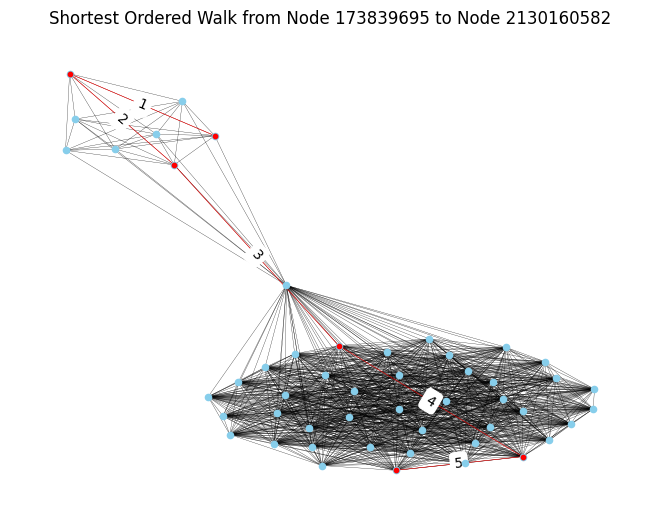

In [ ]:

def visualize_functionality_3(graph, authors_a, starting_node, ending_node,N):
    #compute the path
    path = shortest_ordered_walk(graph, authors_a, starting_node, ending_node,N)

    if path == "There is no such path!":
        print("There is no such path!")
        return

    # Print the papers needed to be crossed in the shortest walk in order
    print(f"Papers needed to be crossed in the shortest walk: {path}")

    graph = top_N_nodes(graph, N) #consider only the top N nodes 
    pos = nx.spring_layout(graph)
    # Convert the path to a list of edges
    edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]

    # Draw the graph
    nx.draw(graph, pos, with_labels=False, font_weight='bold', node_color='skyblue', node_size=20, width=0.2)

    # Draw the shortest walk and label edges with the order
    labels = {(path[i], path[i + 1]): i + 1 for i in range(len(path) - 1)}
    nx.draw_networkx_nodes(graph, pos, nodelist=path, node_color='red', node_size=10)
    nx.draw_networkx_edges(graph, pos, edgelist=edges, edge_color='red', width=0.4)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)

    plt.title(f"Shortest Ordered Walk from Node {starting_node} to Node {ending_node}")
    plt.show()


visualize_functionality_3(G_collab, [2065847026, 2240988444], starting_node=173839695, ending_node=2130160582,N=50)



The red path is the walk we want to follow to go from the starting to the ending node while touching all the nodes from the subgraph.

 ### Visualization 4 - Visualize the disconnected graph 
 We anticipate seeing the Functionality 4 report in Visualization 4. To be more specific, we expect you to have the following report format:
 - Print the number of the links that should be disconnected 
 - Plot the original graph 
 - Plot the graph after removing the links and identify the two nodes
---

Number of links to disconnect: 4


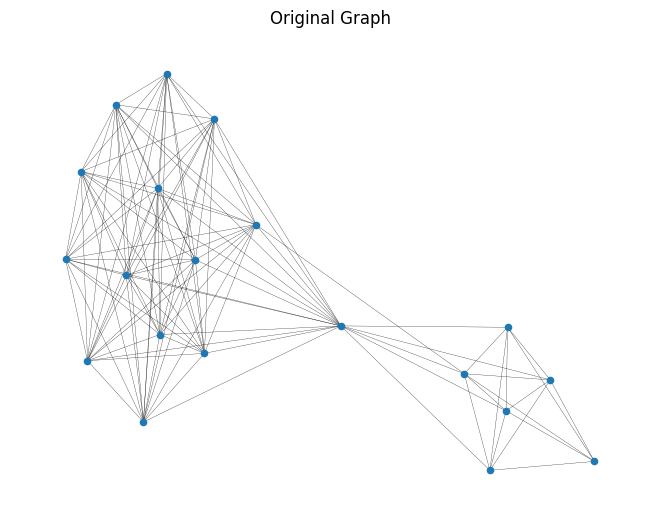

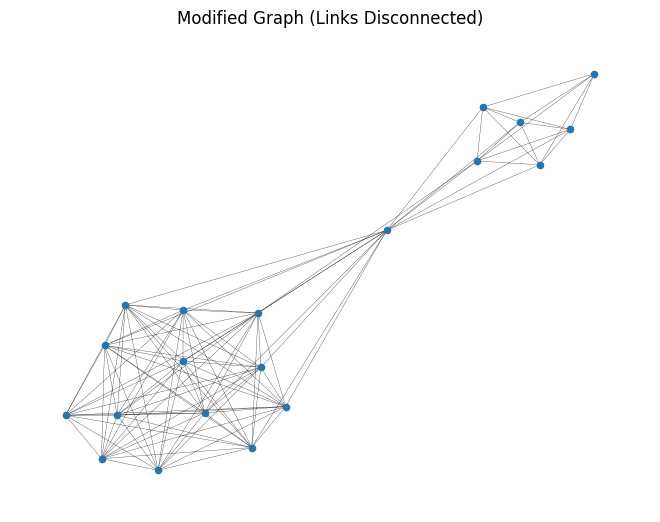

In [26]:
def visualize_functionality_4(graph, result):
    # Print the number of links that should be disconnected
    print(f"Number of links to disconnect: {result[0]}")

    # Plot the original graph
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=False, font_weight='bold', node_size=20, width=0.2)
    plt.title("Original Graph")
    plt.show()

    # Plot the modified graph after disconnecting links
    graph_copy = graph.copy()
    graph_copy.remove_edges_from(result[1]) #remove the edges, the rest stay the same
    pos_modified = nx.spring_layout(graph_copy)
    nx.draw(graph_copy, pos_modified, with_labels=False, font_weight='bold', node_size=20, width=0.2)
    plt.title("Modified Graph (Links Disconnected)")
    plt.show()

# Example considering only the top 20 nodes for degree to make it acceptably fast
top_20_nodes = sorted(G_collab.degree(), key=lambda x: x[1], reverse=True)[:20]
top_20_node_ids = [node[0] for node in top_20_nodes]

result_4 = disconnecting_graphs(G_collab, 332422508, 1984280187, 10)
visualize_functionality_4(G_collab.subgraph(top_20_node_ids), result_4)


### Visualization 5 - Visualize the communities
We anticipate seeing the Functionality 5 report in Visualization 5. To be more specific, we expect you to have the following report format:

 - Print the number of links that should be removed to have the communities
 - A table depicting the communities and the papers that belong to each community
 - Plot the original graph 
 - Plot the graph showing the communities in the network 
 - Plot the final graph and identify the community/communities of Paper_1 and Paper_2

---

Number of links to be removed to have the communities: 18


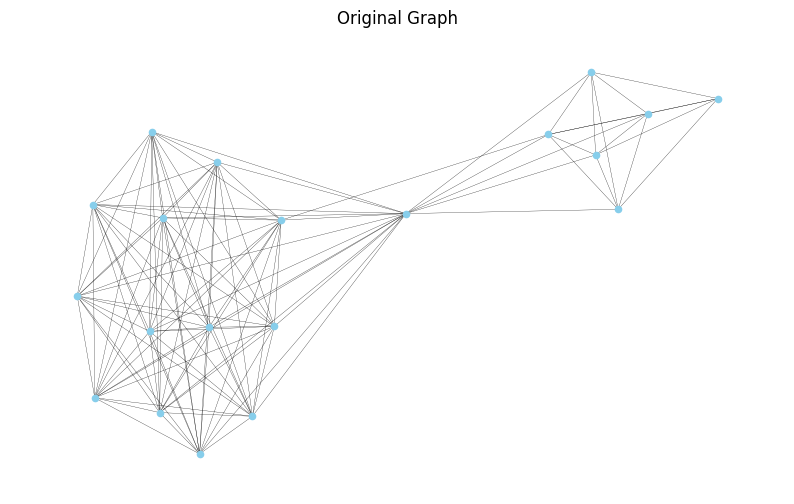

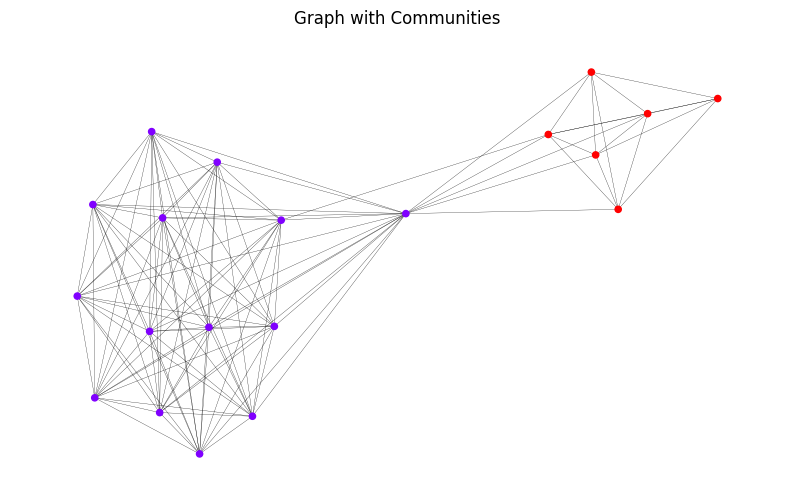

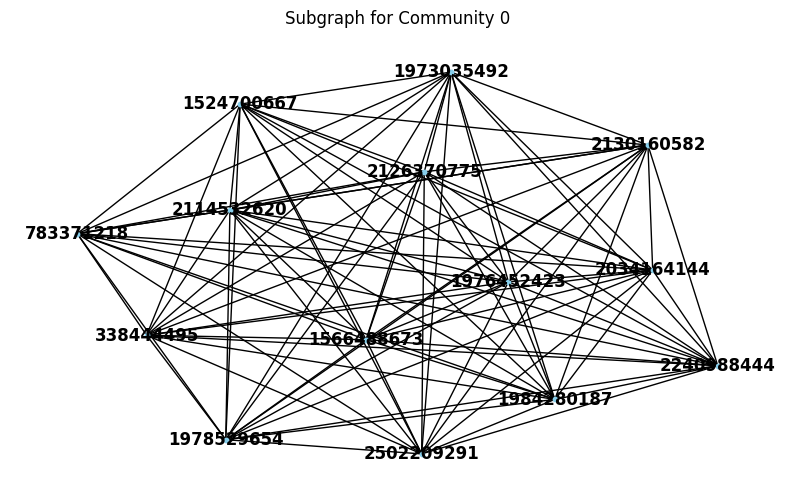

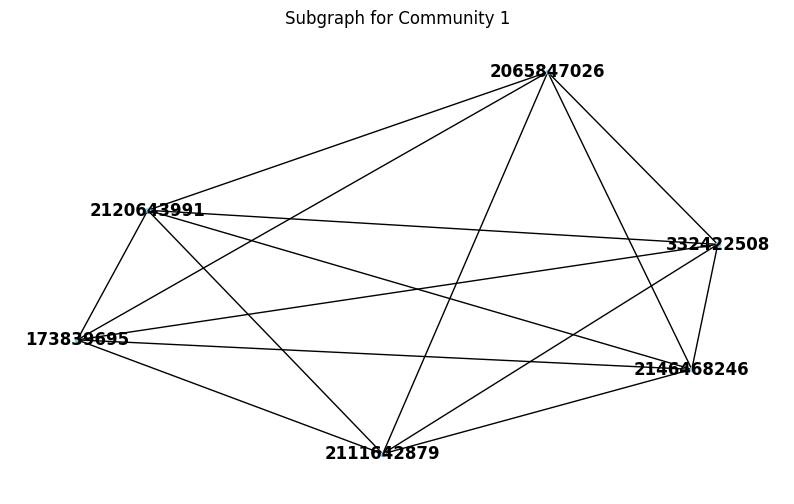

Community of Paper_1: 0
Community of Paper_2: 1


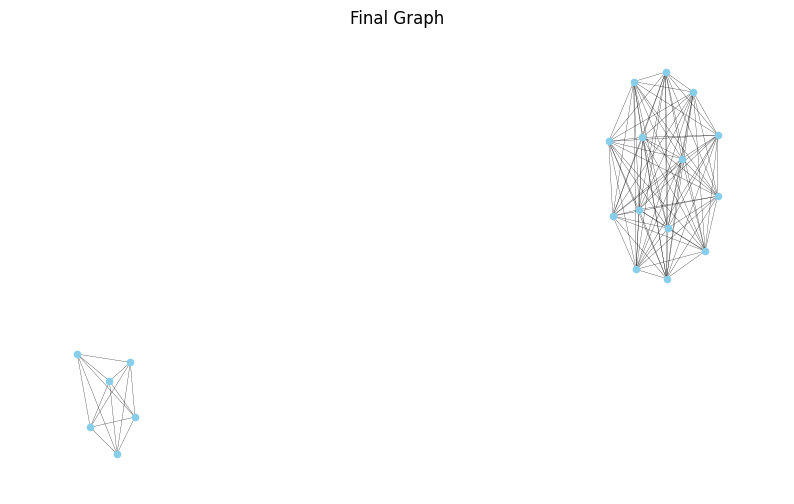

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_functionality_5(graph, communities, paper_1, paper_2):
    # Print the number of links that should be removed to have the communities
    num_links_to_remove = sum(len(community) - 1 for community in communities)
    print(f"Number of links to be removed to have the communities: {num_links_to_remove}")

    # Create a mapping of nodes to their respective community index
    node_to_community = {node: i for i, community in enumerate(communities) for node in community}

    # Filter out nodes not in any community
    colored_nodes = {node: node_to_community.get(node, -1) for node in graph.nodes}

    # Plot the original graph
    pos_original = nx.spring_layout(graph)
    plt.figure(figsize=(10, 6))
    plt.title("Original Graph")
    nx.draw(graph, pos=pos_original, with_labels=False, font_weight='bold', node_color='skyblue', node_size=20, width=0.2)
    plt.show()

    if colored_nodes:
        # Plot the graph showing the communities in the network
        node_colors = [colored_nodes[node] for node in graph.nodes]
        plt.figure(figsize=(10, 6))
        plt.title("Graph with Communities")
        nx.draw(graph, pos=pos_original, with_labels=False, font_weight='bold', node_color=node_colors, cmap=plt.cm.rainbow, node_size=20, width=0.2)
        plt.show()

        # Plot the subgraph we created
        for community_index, community_nodes in enumerate(communities):
            subgraph = graph.subgraph(community_nodes)
            pos_subgraph = nx.spring_layout(subgraph)
            plt.figure(figsize=(10, 6))
            plt.title(f"Subgraph for Community {community_index}")
            nx.draw(subgraph, pos=pos_subgraph, with_labels=True, font_weight='bold', node_color='skyblue', node_size=10)
            plt.show()
    else:
        print("No nodes with valid community indices to visualize.")

        # Plot the final graph and identify the community/communities of Paper_1 and Paper_2
    final_graph = graph.copy()

    # Identify the edges to be removed based on communities
    # Identify the edges to be removed based on communities
    edges_to_remove = [(u, v) for u, v in graph.edges if colored_nodes[u] != colored_nodes[v]]
    final_graph.remove_edges_from(edges_to_remove)


    # Position nodes using a shell layout
    pos_final = nx.spring_layout(final_graph)
    plt.figure(figsize=(10, 6))
    plt.title("Final Graph")
    nx.draw(final_graph, pos=pos_final, with_labels=False, font_weight='bold', node_color='skyblue', node_size=20, width=0.2)

    # Identify the community/communities of Paper_1 and Paper_2
    community_of_paper_1 = colored_nodes.get(paper_1, -1)
    community_of_paper_2 = colored_nodes.get(paper_2, -1)
    print(f"Community of Paper_1: {community_of_paper_1}")
    print(f"Community of Paper_2: {community_of_paper_2}")

    plt.show()



# Also this time only on the top 20 nodes
top_20_nodes = sorted(G_collab.degree(), key=lambda x: x[1], reverse=True)[:20]
top_20_node_ids = [node[0] for node in top_20_nodes]
result_5 = extracting_communities(G_collab, 1973035492, 2120643991, 20)
visualize_functionality_5(G_collab.subgraph(top_20_node_ids), result_5[1], 1973035492, 2120643991)


